Import Data from File and Calculate $\Delta$F/F

In [1]:
# Load raw data
import numpy as np
from wfield import load_stack
raw_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/'
raw_file = 'ctb09_spontaneous_dark_run000_00000000_1_512_512_uint16.dat'
raw = load_stack(raw_path + raw_file)

# Grab reference frame for plotting
ref_frame = raw[1].squeeze().astype('float')

# Generate deltaF/F matrix
F = np.percentile(raw.squeeze(), 20, axis=0)
dFF = (raw.squeeze() - F)

Set Mask to Fit Cranial Window

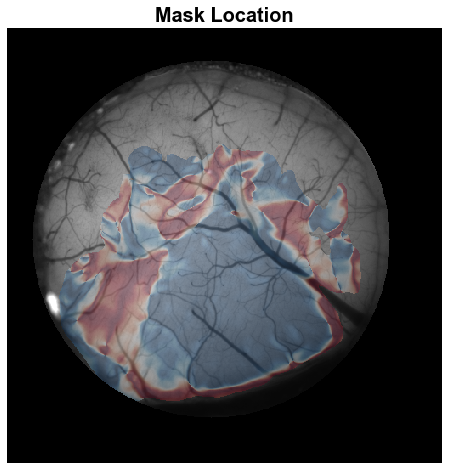

In [2]:
class Cursor:
    '''Define crosshair cursor (from matplotlib documentation).'''
    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()


# Plot reference frame and get user input for center and edge points of circular mask
import matplotlib.pyplot as plt
%matplotlib qt5
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.axis('off')
ax.set_title('Select Center Point and Edge Point for Circular Mask:', fontsize=20, color='k')
fig.set_size_inches(10, 10)
cursor = Cursor(ax)
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)
mask_coors = plt.ginput(n=2, timeout=-1)
plt.close('all')

# Generate mask and get indices to set as nan
import cv2
mask = np.zeros(ref_frame.shape, dtype=np.uint8)
radius = np.linalg.norm(np.array(mask_coors[1]) - np.array(mask_coors[0]))
circle = cv2.circle(mask, (int(mask_coors[0][0]),int(mask_coors[0][1])), int(radius), (255,255,255), -1).astype('float')
circle[circle == 255] = np.nan
mask_idx = (tuple(np.where(mask == 0)[0]), tuple(np.where(mask == 0)[1]))

# Load sign map
signmap_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
signmap_file = 'signmap.csv'
signmap = np.loadtxt(signmap_path + signmap_file)

# Plot reference frame and sign map to check mask placement
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.imshow(circle, cmap='gray', alpha=1)
ax.set_title('Mask Location', fontsize=20, color='k')
ax.axis('off')
fig.set_size_inches(8, 8)

Mask Reference Frame & $\Delta$F/F Matrix

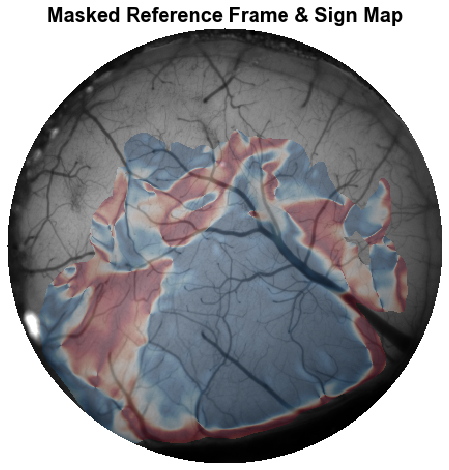

In [3]:
# Set pixel window size for correlation map
window_size = 2

# Mask reference frame and remove edges with all nan, accounting for pixel window size
np.add.at(ref_frame, mask_idx, np.nan)
row_mask = np.where(~np.isnan(ref_frame).all(axis=1))[0]
row_mask = row_mask[range(window_size * np.floor_divide(row_mask.shape[0], window_size))]
col_mask = np.where(~np.isnan(ref_frame).all(axis=0))[0]
col_mask = col_mask[range(window_size * np.floor_divide(col_mask.shape[0], window_size))]
edge_mask = np.ix_(row_mask, col_mask)
ref_frame = ref_frame[edge_mask]

# Mask sign map
np.add.at(signmap, mask_idx, np.nan)
signmap = signmap[edge_mask]

# Plot masked reference frame and sign map
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.set_title('Masked Reference Frame & Sign Map', fontsize=20, color='k')
ax.axis('off')
fig.set_size_inches(8, 8)

# Mask deltaF/F matrix
dFF_masked = []
for frame in dFF:
     np.add.at(frame, mask_idx, np.nan)
     dFF_masked.append(frame[edge_mask])
dFF_masked = np.asarray(dFF_masked)

Get Visual Area Boundaries from Sign Map for Plotting against SCA Maps

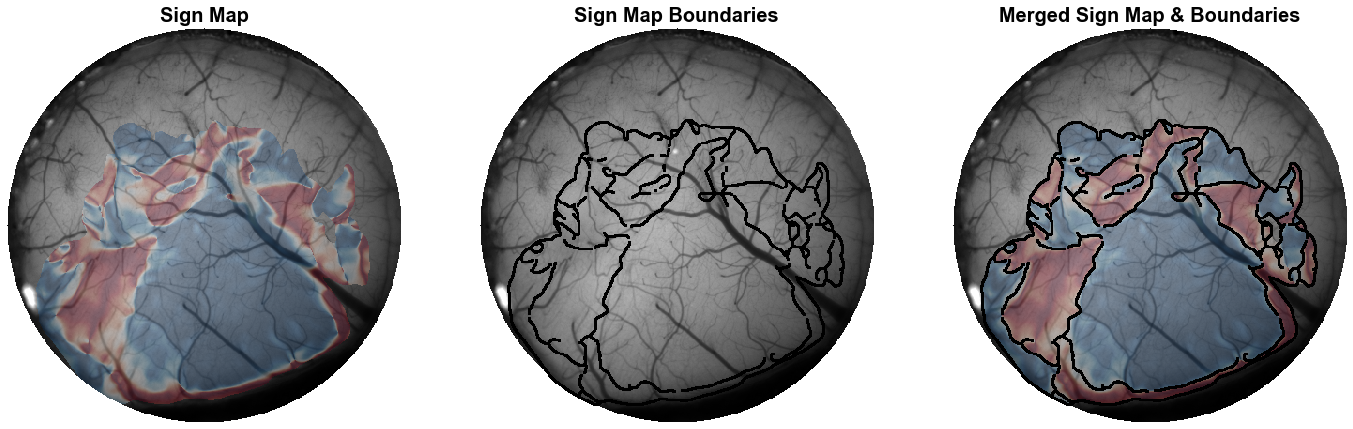

In [4]:
def get_signmap_boundaries(signmap, dilation_factor):
    '''
    Get binary image of sign map boundaries by:
        1) Thresholding sign map around zero to detect boundary regions.
        2) Skeletonizing thresholded sign map to reduce thickness of certain boundary regions.
        3) Dilating skeletonized image by dilation_factor to make boundary thickness uniform and suitable for display purposes.
    '''
    # Detect outer edges of sign map (floats bordering nans) and set to 0
    signmap_threshold = signmap.copy()
    kernel_edge = np.array([[-1, -1, -1],
                            [-1, 1, -1],
                            [-1, -1 , -1]])
    for row in np.arange(1, signmap_threshold.shape[0] - 1):
        for col in np.arange(1, signmap_threshold.shape[1] - 1):
            curr_idx = np.ix_((row - 1, row, row + 1),(col - 1, col, col + 1))
            if not (np.isnan(signmap[row,col]) and
                        np.isnan(np.tensordot(kernel_edge, signmap_threshold[curr_idx], 
                                              axes=((0,1),(0,1))))):
                signmap_threshold[curr_idx] = 0

    # Threshold the sign map around 0 to detect visual area boundaries.
    np.add.at(signmap_threshold, np.logical_or(signmap < -0.35, signmap > 0.35), np.nan)

    # Skeletonize, then dilate thresholded sign map
    from skimage.morphology import skeletonize
    signmap_skeleton = skeletonize(~np.isnan(signmap_threshold))
    kernel_dilate = np.ones((dilation_factor, dilation_factor), np.uint8)
    signmap_boundaries = cv2.dilate(signmap_skeleton.astype('float'), kernel_dilate, iterations=1)
    signmap_boundaries[signmap_boundaries == 0] = np.nan
    return signmap_boundaries


# Get sign map boundaries, use dilation factor of 3 (good boundary thickness)
signmap_boundaries = get_signmap_boundaries(signmap, 3)

# Plot sign map, sign map boundaries, and merge
%matplotlib inline
fig, axs = plt.subplots(1,3)
axs[0].imshow(ref_frame, cmap='gray')
axs[0].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[0].set_title('Sign Map', fontsize=20, color='k')
axs[0].axis('off')
axs[1].imshow(ref_frame, cmap='gray')
axs[1].imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
axs[1].set_title('Sign Map Boundaries', fontsize=20, color='k')
axs[1].axis('off')
axs[2].imshow(ref_frame, cmap='gray')
axs[2].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[2].imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
axs[2].set_title('Merged Sign Map & Boundaries', fontsize=20, color='k')
axs[2].axis('off')
fig.set_size_inches(24, 8)

Generate Matrix of Window Means and Indices

In [5]:
# Get mean of each window and stack into seed-by-time matrix for calculating SCA map by projection, and get row/column indices
# for each window to map projection output vector back into image
window_mat = []
window_idx = np.arange(dFF_masked.shape[1]).reshape(int(dFF_masked.shape[1]/window_size), window_size)
window_idx_row = np.empty((0,0))
window_idx_col = np.empty((0,0))
for row_seed in range(int(dFF_masked.shape[1]/window_size)):
    for col_seed in range(int(dFF_masked.shape[2]/window_size)):
        window_mean = dFF_masked[np.ix_(range(dFF_masked.shape[0]),window_idx[row_seed,:],window_idx[col_seed,:])].mean(axis=(1,2))
        window_mat.append(window_mean)
        window_idx_row = np.append(window_idx_row, np.repeat(np.arange(window_size), window_size) + window_idx[row_seed,0])
        window_idx_col = np.append(window_idx_col, np.tile(np.arange(window_size), window_size) + window_idx[col_seed,0])
from scipy.stats import zscore
window_mat = zscore(np.asarray(window_mat), axis=1)


def get_corr_map(in_coors):
    '''
    Generate seed-based correlation map for a given seed coordinate, in_coors.
    This function relies on variables generated by the previous code block.
    '''
    row_loc = np.isin(np.split(window_idx_row, len(window_idx_row) / window_size**2), in_coors[0])
    col_loc = np.isin(np.split(window_idx_col, len(window_idx_col) / window_size**2), in_coors[1])
    seed_loc = np.where(np.sum(np.concatenate((row_loc, col_loc), axis=1), axis=1) == window_size*2)[0][0]
    corr_list = np.matmul(window_mat, window_mat[seed_loc,:])/window_mat.shape[1]
    corr_list = np.repeat(corr_list, window_size**2)
    corr_mat = np.zeros((dFF_masked.shape[1], dFF_masked.shape[2]))
    corr_mat[window_idx_row.astype('int'),window_idx_col.astype('int')] = corr_list
    return corr_mat

Create PyQt GUI for Interacting with SCA Map

In [27]:
# Load and mask azimuth and elevation data for displaying on SCA map
azimuth_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
azimuth_file = 'azimuth.csv'
azimuth = np.loadtxt(azimuth_path + azimuth_file)
np.add.at(azimuth, mask_idx, np.nan)
azimuth = azimuth[edge_mask]
elevation_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
elevation_file = 'elevation.csv'
elevation = np.loadtxt(elevation_path + elevation_file)
np.add.at(elevation, mask_idx, np.nan)
elevation = elevation[edge_mask]

import sys
from PyQt5 import QtCore, QtGui, QtWidgets
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg, NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure
from matplotlib.backend_bases import MouseButton
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter


class MplCanvas(FigureCanvasQTAgg):
    '''Define matplotlib canvas for plotting interactive SCA map.'''
    def __init__(self, parent=None, width=11, height=10, dpi=100):
        '''
        Initialize: 
            1) Figure.
            2) Axes.
            3) Variables to share with PyQt application window.
        Connect to events:
            1) Mouse motion event for moving seed.
            2) Left mouse click for pausing/unpausing SCA map.
            3) Scroll event for increasing/decreasing lower SCA colormap bound.
        '''
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)
        # Initialize variables for sharing with main application window
        self.corr_bounds = [0.8, 1.0]
        self.curr_coors = [round(dFF_masked.shape[1]/2), round(dFF_masked.shape[2]/2)]
        self.corr_mat = get_corr_map(self.curr_coors)
        self.slider_changed = False
        self.pause_map = False
        self.signmap_checked = False
        self.azimuth_checked = False
        self.elevation_checked = False
        # Connect to events
        self.binding_id = self.mpl_connect('motion_notify_event', self.map_on_move)
        self.mpl_connect('button_press_event', self.freeze_on_click)
        self.mpl_connect('scroll_event', self.slide_on_scroll)

    def map_on_move(self, event):
        '''
        Redraw axes based on current user selections, including:
            1) SCA map with seed at current cursor location.
            2) Scatter point at current seed location.
            3) Sign map outline on/off based on checkbox.
            4) Azimuth contour on/off based on checkbox.
            5) Elevation contour on/off based on checkbox.
            6) Colorbar matching current upper/lower slider bounds.
        '''
        if event.inaxes:
            # Recalculate SCA map for current cursor (seed) location and redraw axes with new SCA map and seed location
            if self.pause_map == False:
                self.curr_coors = np.round([event.ydata, event.xdata])
                self.corr_mat = get_corr_map(self.curr_coors)
                self.cr_im.remove()
                self.cr_im = self.axes.imshow(self.corr_mat, cmap='RdBu_r', clim=self.corr_bounds, alpha=0.5)
                self.point.remove()
                self.point = self.axes.scatter(event.xdata, event.ydata, color='k')
            # Redraw sign map boundaries
            if self.signmap_checked == True:
                self.sb_im.remove()
                self.sb_im = self.axes.imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
            # Redraw azimuth contour
            if self.azimuth_checked == True:
                for artist in self.az_ct.collections:
                    artist.remove()
                self.az_ct = self.axes.contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='jet_r', alpha=1, linewidths=0.5)
            # Redraw elevation contour
            if self.elevation_checked == True:
                for artist in self.el_ct.collections:
                    artist.remove()
                self.el_ct = self.axes.contour(elevation, levels=np.arange(0, 100, 5), cmap='jet_r', alpha=1, linewidths=0.5)
            # Redraw colorbar
            if self.slider_changed == True:
                self.cb_ax.remove()
                self.cb_ax = inset_axes(self.axes, width='5%', height='90%', loc='center left', borderpad=-5)
                colorbar = fig.colorbar(self.cr_im, cax=self.cb_ax)
                colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
                self.cb_ax.yaxis.tick_left()
                self.cb_ax.yaxis.set_label_position('left')
                self.cb_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                self.cb_ax.tick_params(labelsize=15)
                self.slider_changed = False
            self.draw()

    def freeze_on_click(self, event):
        '''Freeze/unfreeze SCA map updating if left mouse button is clicked.'''
        if (event.button is MouseButton.LEFT) & (self.pause_map == False):
            self.pause_map = True
        elif (event.button is MouseButton.LEFT) & (self.pause_map == True):
            self.pause_map = False
            
    def slide_on_scroll(self, event):
        '''Increase/decrease lower SCA colormap bound if scroll wheel is moved.'''
        if event.button == 'up':
            w.slider_low.setValue(w.slider_low.value() + 5)
        elif event.button == 'down':
            w.slider_low.setValue(w.slider_low.value() - 5)


class MainWindow(QtWidgets.QMainWindow):
    '''Define PyQt main application window containing interactive SCA map, control widgets, and toolbar.'''
    def __init__(self, *args, **kwargs):
        '''
        Initialize main application window containing:
            1) Matplotlib canvas with interactive SCA map.
            2) Checkboxes for showing/hiding sign map outline and azimuth/elevation contours.
            3) Sliders for upper and lower SCA colormap bounds.
            4) Toolbar.
        '''
        super(MainWindow, self).__init__(*args, **kwargs)
        sc = MplCanvas(self, width=11, height=10, dpi=100)
        # Draw static reference frame
        sc.axes.imshow(ref_frame, cmap='gray')
        # Draw initial SCA map and seed location (center of image)
        sc.cr_im = sc.axes.imshow(sc.corr_mat, cmap='RdBu_r', clim=sc.corr_bounds, alpha=0.5)
        sc.point = sc.axes.scatter(sc.curr_coors[1], sc.curr_coors[0], color='k')
        # Draw initial colorbar (bounded between 0.8 and 1.0) on the left of SCA map
        sc.cb_ax = inset_axes(sc.axes, width='5%', height='90%', loc='center left', borderpad=-5)
        colorbar = fig.colorbar(sc.cr_im, cax=sc.cb_ax)
        colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
        sc.cb_ax.yaxis.tick_left()
        sc.cb_ax.yaxis.set_label_position('left')
        sc.cb_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        sc.cb_ax.tick_params(labelsize=15)
        sc.axes.axis('off')
        # Draw instructions for interactive SCA map on the right
        sc.axes.annotate('Left Click', (1.17,0.65), xycoords='axes fraction', horizontalalignment='center', fontweight='bold')
        sc.axes.annotate('Freeze/Unfreeze Map', (1.17,0.6), xycoords='axes fraction', horizontalalignment='center')
        sc.axes.annotate('Scroll Up/Down', (1.17,0.45), xycoords='axes fraction', horizontalalignment='center', fontweight='bold')
        sc.axes.annotate('Increase/Decrease', (1.17,0.4), xycoords='axes fraction', horizontalalignment='center')
        sc.axes.annotate('Lower Correlation Bound', (1.17,0.37), xycoords='axes fraction', horizontalalignment='center')
        
        # Create toolbar
        toolbar = NavigationToolbar(sc, self)
        # Create, configure, and connect to sliders for upper and lower SCA colormap bounds
        self.slider_upp = QtWidgets.QSlider(QtCore.Qt.Vertical)
        self.slider_upp.setMinimum(-100)
        self.slider_upp.setMaximum(100)
        self.slider_upp.setTickPosition(QtWidgets.QSlider.TicksLeft)
        self.slider_upp.setTickInterval(5)
        self.slider_low = QtWidgets.QSlider(QtCore.Qt.Vertical)
        self.slider_low.setMinimum(-100)
        self.slider_low.setMaximum(100)
        self.slider_low.setTickPosition(QtWidgets.QSlider.TicksLeft)
        self.slider_low.setTickInterval(5)
        self.slider_upp.valueChanged.connect(lambda state, ax = sc: self.sliderValueChange(state, ax))
        self.slider_low.valueChanged.connect(lambda state, ax = sc: self.sliderValueChange(state, ax))
        self.slider_upp.setValue(100)
        self.slider_low.setValue(80)
        # Create main labels for SCA colormap bound sliders
        self.slider_upp_lbl_top = QtWidgets.QLabel()
        self.slider_upp_lbl_top.setText('Maximum Correlation Bound')
        self.slider_upp_lbl_top.setWordWrap(True)
        self.slider_upp_lbl_top.setAlignment(QtCore.Qt.AlignCenter)
        self.slider_low_lbl_top = QtWidgets.QLabel()
        self.slider_low_lbl_top.setText('Minimum Correlation Bound')
        self.slider_low_lbl_top.setWordWrap(True)
        self.slider_low_lbl_top.setAlignment(QtCore.Qt.AlignCenter)
        # Create correlation value labels for SCA colormap bound sliders
        self.slider_upp_lbl_p10 = QtWidgets.QLabel()
        self.slider_upp_lbl_p10.setText('1.0')
        self.slider_upp_lbl_p10.setAlignment(QtCore.Qt.AlignRight)
        self.slider_upp_lbl_p05 = QtWidgets.QLabel()
        self.slider_upp_lbl_p05.setText('0.5')
        self.slider_upp_lbl_p05.setAlignment(QtCore.Qt.AlignRight)
        self.slider_upp_lbl_000 = QtWidgets.QLabel()
        self.slider_upp_lbl_000.setText('0.0')
        self.slider_upp_lbl_000.setAlignment(QtCore.Qt.AlignRight)
        self.slider_upp_lbl_n05 = QtWidgets.QLabel()
        self.slider_upp_lbl_n05.setText('-0.5')
        self.slider_upp_lbl_n05.setAlignment(QtCore.Qt.AlignRight)
        self.slider_upp_lbl_n10 = QtWidgets.QLabel()
        self.slider_upp_lbl_n10.setText('-1.0')
        self.slider_upp_lbl_n10.setAlignment(QtCore.Qt.AlignRight)
        self.slider_low_lbl_p10 = QtWidgets.QLabel()
        self.slider_low_lbl_p10.setText('1.0')
        self.slider_low_lbl_p10.setAlignment(QtCore.Qt.AlignRight)
        self.slider_low_lbl_p05 = QtWidgets.QLabel()
        self.slider_low_lbl_p05.setText('0.5')
        self.slider_low_lbl_p05.setAlignment(QtCore.Qt.AlignRight)
        self.slider_low_lbl_000 = QtWidgets.QLabel()
        self.slider_low_lbl_000.setText('0.0')
        self.slider_low_lbl_000.setAlignment(QtCore.Qt.AlignRight)
        self.slider_low_lbl_n05 = QtWidgets.QLabel()
        self.slider_low_lbl_n05.setText('-0.5')
        self.slider_low_lbl_n05.setAlignment(QtCore.Qt.AlignRight)
        self.slider_low_lbl_n10 = QtWidgets.QLabel()
        self.slider_low_lbl_n10.setText('-1.0')
        self.slider_low_lbl_n10.setAlignment(QtCore.Qt.AlignRight)
        # Create, configure, and connect to checkboxes for displaying sign map boundaries and azimuth/elevation contours
        self.checkbox_sm = QtWidgets.QCheckBox('Sign Map Boundaries', self)
        self.checkbox_sm.setFont(QtGui.QFont('Arial', 20))
        self.checkbox_az = QtWidgets.QCheckBox('Azimuth', self)
        self.checkbox_az.setFont(QtGui.QFont('Arial', 20))
        self.checkbox_el = QtWidgets.QCheckBox('Elevation', self)
        self.checkbox_el.setFont(QtGui.QFont('Arial', 20))
        self.checkbox_sm.stateChanged.connect(
            lambda state, checkbox_name = 'Sign Map Boundaries', ax = sc: self.clickBox(state, checkbox_name, ax))
        self.checkbox_az.stateChanged.connect(
            lambda state, checkbox_name = 'Azimuth', ax = sc: self.clickBox(state, checkbox_name, ax))
        self.checkbox_el.stateChanged.connect(
            lambda state, checkbox_name = 'Elevation', ax = sc: self.clickBox(state, checkbox_name, ax))
        
        # Create grid layout
        layout = QtWidgets.QGridLayout()
        # Add matplotlib canvas
        layout.addWidget(sc, 2, 2, 42, 6)
        # Add toolbar
        layout.addWidget(toolbar, 0, 0, 1, 8)
        # Add checkboxes
        layout.addWidget(self.checkbox_sm, 1, 2, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.checkbox_az, 1, 4, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.checkbox_el, 1, 6, 1, 2, QtCore.Qt.AlignCenter)
        # Add upper slider and labels
        layout.addWidget(self.slider_upp, 3, 1, 20, 2, QtCore.Qt.AlignLeft)
        layout.addWidget(self.slider_upp_lbl_top, 2, 0, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.slider_upp_lbl_p10, 3, 0, 2, 1, QtCore.Qt.AlignBottom)
        layout.addWidget(self.slider_upp_lbl_p05, 8, 0, 1, 1, QtCore.Qt.AlignTop)
        layout.addWidget(self.slider_upp_lbl_000, 12, 0, 2, 1, QtCore.Qt.AlignVCenter)
        layout.addWidget(self.slider_upp_lbl_n05, 17, 0, 1, 1, QtCore.Qt.AlignTop)
        layout.addWidget(self.slider_upp_lbl_n10, 21, 0, 2, 1, QtCore.Qt.AlignVCenter)
        # Add lower slider and labels
        layout.addWidget(self.slider_low, 24, 1, 20, 2, QtCore.Qt.AlignLeft)
        layout.addWidget(self.slider_low_lbl_top, 23, 0, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.slider_low_lbl_p10, 24, 0, 2, 1, QtCore.Qt.AlignBottom)
        layout.addWidget(self.slider_low_lbl_p05, 29, 0, 1, 1, QtCore.Qt.AlignTop)
        layout.addWidget(self.slider_low_lbl_000, 33, 0, 2, 1, QtCore.Qt.AlignVCenter)
        layout.addWidget(self.slider_low_lbl_n05, 38, 0, 1, 1, QtCore.Qt.AlignTop)
        layout.addWidget(self.slider_low_lbl_n10, 42, 0, 2, 1, QtCore.Qt.AlignVCenter)

        # Create a placeholder widget to hold the layout and show
        widget = QtWidgets.QWidget()
        widget.setLayout(layout)
        self.setCentralWidget(widget)
        self.show()
        
    def clickBox(self, state, checkbox_name, ax):
        '''Add/remove sign map boundaries, azimuth contour, or elevation contour when checkbox is clicked/unclicked.'''
        if (checkbox_name == 'Sign Map Boundaries') & (state == QtCore.Qt.Checked):
            ax.signmap_checked = True
            ax.sb_im = ax.axes.imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
            ax.draw()
        elif (checkbox_name == 'Sign Map Boundaries') & (state == QtCore.Qt.Unchecked):
            ax.signmap_checked = False
            ax.sb_im.remove()
            ax.draw()
        if (checkbox_name == 'Azimuth') & (state == QtCore.Qt.Checked):
            ax.azimuth_checked = True
            ax.az_ct = ax.axes.contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='jet_r', alpha=1, linewidths=0.5)
            ax.draw()
        elif (checkbox_name == 'Azimuth') & (state == QtCore.Qt.Unchecked):
            ax.azimuth_checked = False
            for artist in ax.az_ct.collections:
                artist.remove()
            ax.draw()
        if (checkbox_name == 'Elevation') & (state == QtCore.Qt.Checked):
            ax.elevation_checked = True
            ax.el_ct = ax.axes.contour(elevation, levels=np.arange(0, 100, 5), cmap='jet_r', alpha=1, linewidths=0.5)
            ax.draw()
        elif (checkbox_name == 'Elevation') & (state == QtCore.Qt.Unchecked):
            ax.elevation_checked = False
            for artist in ax.el_ct.collections:
                artist.remove()
            ax.draw()

    def sliderValueChange(self, state, ax):
        '''Redraw SCA map and colorbar when upper/lower SCA colormap bounds are changed with sliders.'''
        if self.slider_upp.value() >= self.slider_low.value():
            ax.slider_changed = True
            ax.corr_bounds = [self.slider_low.value()/100, self.slider_upp.value()/100]
            ax.cr_im.remove()
            ax.cr_im = ax.axes.imshow(ax.corr_mat, cmap='RdBu_r', clim=ax.corr_bounds, alpha=0.5)
            if ax.signmap_checked == True:
                ax.sb_im.remove()
                ax.sb_im = ax.axes.imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
            ax.cb_ax.remove()
            ax.cb_ax = inset_axes(ax.axes, width='5%', height='90%', loc='center left', borderpad=-5)
            colorbar = fig.colorbar(ax.cr_im, cax=ax.cb_ax)
            colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
            ax.cb_ax.yaxis.tick_left()
            ax.cb_ax.yaxis.set_label_position('left')
            ax.cb_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.cb_ax.tick_params(labelsize=15)
            ax.draw()


# Start main application window and take screenshot
app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
w = MainWindow()
app.exec_()
# Display inline screenshot of GUI

0